In [2]:
import pandas as pd
import glob 
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
import seaborn as sns

save_path = 'Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [27]:

summary_df = pd.read_csv("../Logs/Summary.csv")

planners = ['GlobalPlanPP', "FollowTheGap", "EndToEnd"]
test_ids = ["mu70", "Std", "TD3v3"]

neat_planner_names = ["Pure pursuit", "Follow the gap", "End-to-end"]


In [28]:
print(summary_df)

            Vehicle   TestID MapName  AvgProgress  AvgTime  StdTime  \
0      ConstantMPCC     mu70     aut       0.6047      NaN      NaN   
1      ConstantMPCC     mu70     esp       0.0998      NaN      NaN   
2      ConstantMPCC     mu70     gbr       0.0665      NaN      NaN   
3          EndToEnd    TD3v1     aut       0.9962  40.9600  26.3411   
4          EndToEnd    TD3v2     aut       0.9962  30.2560   0.6303   
5          EndToEnd    TD3v3     aut       0.8165  21.0600   0.6729   
6          EndToEnd    TD3v4     aut       0.8960  25.1100   1.6516   
7          EndToEnd  TestTD3     aut       0.8727  31.4267   0.3946   
8          EndToEnd    TD3v1     esp       0.7026  75.2600   0.2546   
9          EndToEnd    TD3v2     esp       0.9953  77.8480   0.5820   
10         EndToEnd    TD3v3     esp       0.7350  47.6800      NaN   
11         EndToEnd    TD3v4     esp       0.4488      NaN      NaN   
12         EndToEnd  TestTD3     esp       0.7745  78.0667   0.1617   
13    

In [31]:

results_df = summary_df.loc[summary_df.Vehicle.isin(planners)]
results_df = results_df.loc[results_df.TestID.isin(test_ids)]

times_df = results_df.pivot(index="Vehicle", columns="MapName", values="AvgTime")
times_df.columns = times_df.columns.str.upper()
times_df.rename(index=dict(zip(planners, neat_planner_names)), inplace=True)
print(times_df)

times_df.to_latex(f"{save_path}benchmark_laptimes.tex", float_format="%.2f")


MapName            AUT     ESP    GBR     MCO
Vehicle                                      
End-to-end      21.060  47.680  40.18  37.270
Follow the gap  19.030  45.744  39.32  35.016
Pure pursuit    18.664  39.216  33.92  30.552


In [43]:
map_name = "esp"
n_laps = 5

lap_dfs = []
for i in range(len(planners)):
    dfs = []
    for lap_n in range(n_laps):
        data = np.load(f"../Logs/{planners[i]}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
        df.steer_a = df.steer_a * 180 / np.pi
        df.yaw = df.yaw * 180 / np.pi
        df.slip = df.slip.abs() * 180 / np.pi

        el_lengths = np.linalg.norm(np.diff(data[:, :2], axis=0), axis=1)
        psi, kappa = tph.calc_head_curv_num.calc_head_curv_num(data[:, :2], el_lengths, False)
        df["curvature"] = kappa * 180 / np.pi
        df["d_steer"] = df.steer_a.diff()
        df["lap_n"] = lap_n
        df["planner"] = planners[i]

        lap_dfs.append(df)

lap_df = pd.concat(lap_dfs)
lap_df.dropna(inplace=True)
print(lap_df.head())


          x         y  steer     speed       yaw  yaw_rate      slip  \
1  0.003994  0.000000  0.000  0.323340  0.000000  0.000000  0.000000   
2  0.022634  0.000000  0.000  0.703740  0.000000  0.000000  0.000000   
3  0.056489  0.000000  0.000  1.084140  0.000000  0.000000  0.000000   
4  0.105236  0.000000  0.064  1.428889  0.000000  0.065865  0.222035   
5  0.166807  0.001083  0.192  1.712596  0.510843  0.543318  2.103703   

     steer_a   speed_a  progress  curvature    d_steer  lap_n       planner  
1   0.000000  4.000000       0.0   0.000000   0.000000      0  GlobalPlanPP  
2   0.000000  4.000000       0.0   0.000000   0.000000      0  GlobalPlanPP  
3  22.918312  3.031224       0.0   6.809432  22.918312      0  GlobalPlanPP  
4  22.918312  3.031224       0.0  23.812286   0.000000      0  GlobalPlanPP  
5  22.918312  3.031224       0.0  43.236183   0.000000      0  GlobalPlanPP  


In [48]:
map_name = "esp"
n_laps = 5

lap_df_drop = lap_df[["slip", "curvature", "d_steer", "planner", "lap_n"]].copy()
lap_avg_view = lap_df_drop.groupby(["planner", "lap_n"])
lap_avg = lap_avg_view.mean()
lap_std = lap_avg_view.std()
lap_avg["max_slip"] = lap_avg_view.max().slip

# print(lap_avg)


mean_df = lap_avg.groupby("planner").mean()
mean_df.columns = ["Mean slip", "Mean curvature", "Mean steer rate", "Max slip"]
mean_df.index = neat_planner_names
print(mean_df)

# times_df.to_latex(f"{save_path}mean_{map_name}_stats.tex", float_format="%.2f")

# std_df = df.groupby("planner").std()
# print(std_df)




                Mean slip  Mean curvature  Mean steer rate   Max slip
Pure pursuit     2.562528        0.441780         0.017591  14.758639
Follow the gap   1.424200       -1.431748         0.004869  17.349928
End-to-end       2.321221       -1.416480        -0.002349   8.008203


Pure pursuit      2.340741
Follow the gap    1.446612
End-to-end        1.631364
dtype: float64


Text(0, 0.5, 'Frequency [%]')

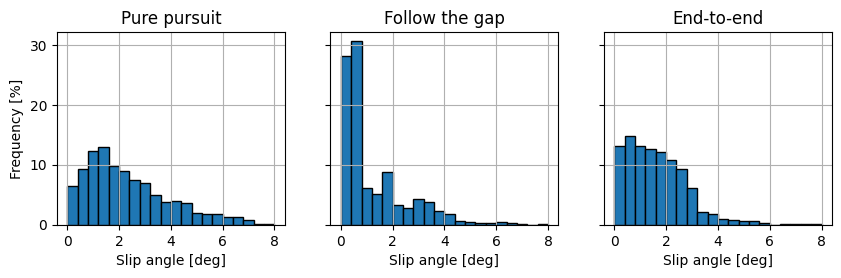

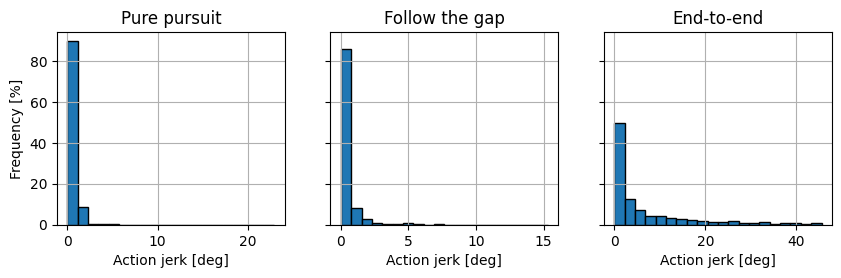

In [26]:
map_name = "esp"
lap_n = 1
from matplotlib.ticker import PercentFormatter

dfs = []
a_dfs = []
for i in range(3):
    data = np.load(f"../Logs/{planners[i]}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df.slip = df.slip * 180 / np.pi
    df_s = df.slip.abs()
    dfs.append(df_s)
    df_a = df.steer_a.diff().abs() * 180 / np.pi
    a_dfs.append(df_a)

df = pd.concat(dfs, axis=1)
df.columns = neat_planner_names
print(df.mean())

fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), sharey=True)
for i in range(3):
    plt.sca(axs[i])
    hist, edges = np.histogram(dfs[i], bins=20, range=(0, 8))
    freq = hist / float(hist.sum()) * 100
    width = np.diff(edges) # edges is bins
    plt.bar(edges[:-1], freq, width=width, align="edge", ec="k")
    plt.xlabel("Slip angle [deg]")
    plt.title(neat_planner_names[i])
    plt.grid(True)

axs[0].set_ylabel("Frequency [%]")

fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), sharey=True)
for i in range(3):
    plt.sca(axs[i])
    a_dfs[i] = a_dfs[i].dropna()
    hist, edges = np.histogram(a_dfs[i], bins=20)
    freq = hist / float(hist.sum()) * 100
    width = np.diff(edges) # edges is bins
    plt.bar(edges[:-1], freq, width=width, align="edge", ec="k")
    plt.xlabel("Action jerk [deg]")
    plt.title(neat_planner_names[i])
    plt.grid(True)

axs[0].set_ylabel("Frequency [%]")


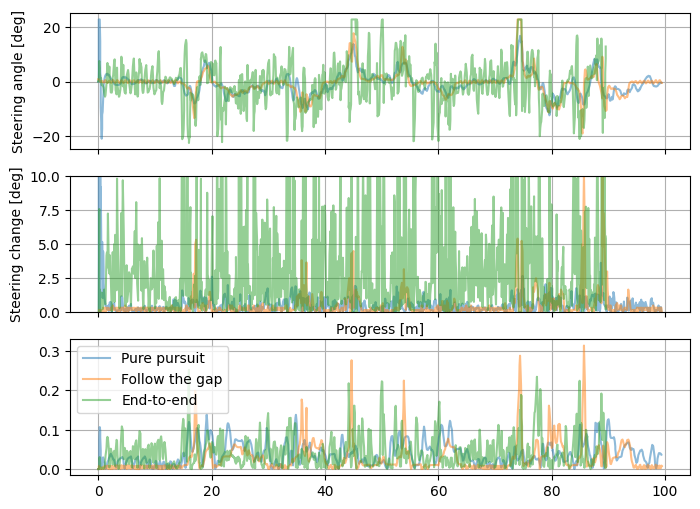

In [19]:
map_name = "esp"
lap_n = 1
from matplotlib.ticker import PercentFormatter

dfs = []
for i in range(3):
    data = np.load(f"../Logs/{planners[i]}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df.steer_a = df.steer_a * 180 / np.pi
    df.progress = df.progress * 100
    df = df[["steer_a", "progress", "slip"]]
    df["d_steer"] = df.steer_a.diff().abs()
    dfs.append(df)

# df = pd.concat(dfs, axis=1)
# df.columns = neat_planner_names

# df_d = df.diff().abs()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax1.set_ylabel("Steering angle [deg]")
ax2.set_xlabel("Progress [m]")
ax2.set_ylabel("Steering change [deg]")

for i in range(3):
    df = dfs[i]
    ax1.plot(df["progress"], df["steer_a"], label=neat_planner_names[i], alpha=0.5)

    ax2.plot(df["progress"], df["d_steer"], label=neat_planner_names[i], alpha=0.5)

    ax3.plot(df["progress"], df["slip"].abs(), label=neat_planner_names[i], alpha=0.5)

ax1.grid(True)
ax2.grid(True)
ax2.set_ylim(0, 10)
ax3.grid(True)

plt.legend()

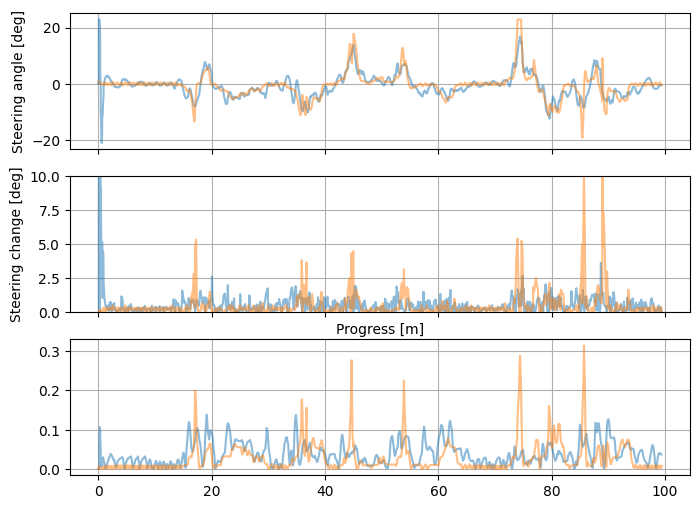

In [20]:
map_name = "esp"
lap_n = 1
from matplotlib.ticker import PercentFormatter

planners = ['GlobalPlanPP', "FollowTheGap", "EndToEnd"]
test_ids = ["mu70", "Std", "TestTD3"]

dfs = []
for i in range(3):
    data = np.load(f"../Logs/{planners[i]}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df.steer_a = df.steer_a * 180 / np.pi
    df.progress = df.progress * 100
    df = df[["steer_a", "progress", "slip"]]
    df["d_steer"] = df.steer_a.diff().abs()
    dfs.append(df)

# df = pd.concat(dfs, axis=1)
# df.columns = neat_planner_names

# df_d = df.diff().abs()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax1.set_ylabel("Steering angle [deg]")
ax2.set_xlabel("Progress [m]")
ax2.set_ylabel("Steering change [deg]")

for i in range(2):
    df = dfs[i]
    ax1.plot(df["progress"], df["steer_a"], label=neat_planner_names[i], alpha=0.5)

    ax2.plot(df["progress"], df["d_steer"], label=neat_planner_names[i], alpha=0.5)

    ax3.plot(df["progress"], df["slip"].abs(), label=neat_planner_names[i], alpha=0.5)

ax1.grid(True)
ax2.grid(True)
ax2.set_ylim(0, 10)
ax3.grid(True)